# Homework 1

### CS328 — Numerical Methods for Visual Computing
- - -

**Out** on Wednesday 28.9, **due** on Wednesday 12.10 (before class).

This notebook contains literate code, i.e. brief fragments of Python surrounded by descriptive text. Please use the same format when submitting your answers. Begin your response to each problem with a <tt>&nbsp;<b>## Solution</b>&nbsp;&nbsp;</tt> markdown cell. Make sure to use the reference Python distribution so that project files can be opened by the TAs. In this course, we use <a href="https://www.continuum.io/downloads">Anaconda 4</a>, specifically the version based on Python 3.5.

<br><div class="alert alert-warning">
Please keep in mind that homework assignments must be done individually.
</div>

### Prelude

The following fragment imports ``time`` (for benchmarking) along with NumPy and Matplotlib and configures the latter to produce nice graphics even on recent high-resolution screens. The import statements at the end establish a shorthand notation for the most common integer and floating point formats.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import time
import numpy as np
from matplotlib import pyplot as plt

from numpy import uint16 as u16
from numpy import uint32 as u32
from numpy import uint64 as u64

from numpy import float16 as f16
from numpy import float32 as f32
from numpy import float64 as f64

When doing the exercises below, please pay attention to the fact that NumPy will often conservatively upgrade the representation of number types in arithmetic operations when the input argument types don't match. This may not be intended and give "too accurate" results—to ensure that computations are performed at the desired precision, all operands must be given using a consistent type.

In [2]:
print(type(f32(1) + 1.0))      # oops, 64 bit output (default Python floats use double precision)
print(type(f32(1) + f32(1.0))) # likely this was the intended behavior
print(type(u32(1) + 2))        # oops, '2' is interpreted as a 64 bit integer
print(type(u32(1) + u32(2)))   # intended behavior

<class 'numpy.float64'>
<class 'numpy.float32'>
<class 'numpy.int64'>
<class 'numpy.uint32'>


We'll also have to fix something: the NumPy square root function ``np.sqrt()`` can change the data type (``dtype``) of the input array in certain situations, so we'll define an alternative version to be used in this homework that does not have this behavior.

In [3]:
def sqrt(x):
    x = np.array(x)
    return np.sqrt(x, dtype=x.dtype)

Finally, two more definitions: the helper functions ``f2i`` and ``i2f``  below reinterpret floating point values as an integers and vice versa. We'll use these in Problem 1 to access the bit-level representation of an IEEE 754 floating point value.

In [4]:
def f2i(value):
   return value.view('u%i' % value.itemsize)

def i2f(value):
   return value.view('f%i' % value.itemsize)

## Problem 1: Warmup: ULPs and Absolute Error (10+10 points)
-- --

The bit-level layout of IEEE754 floating point values is specially designed such that contiguous ranges of positive (or negative) floating point numbers are also contiguous when re-interpreted as integers. Use this property along with the functions ``f2i`` and ``i2f`` and the aliases ``f16`` etc. defined above to answer the following questions:

1. How many floating point values are located between the values ``1`` and ``2``, including the endpoints? How about ``1001`` and ``1002`` ? Give answers for 16, 32, and 64 bit precision variants. <br><br>

2. How large is 1 ULP for the value constant $\pi$ expressed in 64 bit arithmetic? Suppose that we use this value to compute the surface area of the earth given its radius of $\approx 6.353\cdot 10^6m$. Assuming that the earth is perfectly spherical, and that the discretization of $\pi$ is the only source of error in this computation, specify the absolute error in square meters.

## Solution 1

In [5]:
## Part 1
print ("Sub-problem 1:\nDifference between 1 and 2 : ")
for p in [f16, f32, f64]:
    print("Precision", p, f2i(p(2)) - f2i(p(1)))
print ("\nDifference between 1001 and 1002 : ")
for p in [f16, f32, f64]:
    print("Precision : ", p, f2i(p(1002)) - f2i(p(1001)))
print("\n\n\n")


##Part 2
ulp = i2f(f2i(f64(np.pi)) + u64(1)) - f64(np.pi)
print("Sub-problem 2:\nOne ULP for pi is : %s\n" %(ulp))

radius = 6.353*10**6
pi2 = i2f(f2i(f64(np.pi)) + u64(1)) #next number after pi
earth1 = f64(4)*f64(np.pi)*f64((radius**2))
earth2 = f64(4)*f64(pi2)*f64((radius**2))
#earth_correct = 4*np.pi*(radius**2)
print("The absolute error is : %s m²" %((earth2-earth1)))

Sub-problem 1:
Difference between 1 and 2 : 
Precision <class 'numpy.float16'> 1024
Precision <class 'numpy.float32'> 8388608
Precision <class 'numpy.float64'> 4503599627370496

Difference between 1001 and 1002 : 
Precision :  <class 'numpy.float16'> 2
Precision :  <class 'numpy.float32'> 16384
Precision :  <class 'numpy.float64'> 8796093022208




Sub-problem 2:
One ULP for pi is : 4.4408920985e-16

The absolute error is : 0.0625 m²


## Problem 2: Series Approximations, Forward/Backward Error (10 + 10 + 10)
-- --
Consider the power series representation of the sine function, which is defined as

$$
\sin(x)=x-\frac{x^3}{3!}+\frac{x^5}{5!}-\frac{x^7}{7!}+\cdots
$$

1. What are the *relative* forward and backward errors when we approximate this function by its first two series terms? Provide results for $x=2^x$ where $x\in[-1, 0, 1]$.

  What trend do you observe? Plot the two functions in the same graph and justify your observation.<br><br>

2. The relative condition number of a function $f(x)$ at position $x$ is defined as
$$
\frac{\left|f(x+\delta x)-f(x)\right|}{\left|f(x)\right|} \big/ \frac{\left|\delta x\right|}{\left|x\right|}.
$$
  Assuming that the input to our sine approximation is already contaminated with numerical errors, use the above definition to decide where (i.e. at which of the three positions analyzed above) the output is least affected by additional errors introduced by the approximation.<br><br>

3. List three different kinds of numerical problems that can arise when evaluating the above power series with very many terms (e.g. thousands), and what parts of the expression specifically cause them.<br><br>

4. For what argument ranges is evaluating the sine function numerically sensitive? (In the sense that small perturbations of the input mantissa can lead to large changes in the computed result). Why is this the case?

## Solution 2

for x=-1 (2^x = 0.5) :

relative forward error : -0.000539962761037
relative backward error : 0.000589918481271

for x=0 (2^x = 1) :

relative forward error : -0.0096707451849
relative backward error : 0.0148892166623

for x=1 (2^x = 2) :

relative forward error : -0.266833219804
relative backward error : 0.635136171887

We observe that the greater the x, the greater the errors. This is confirmed by the below graph


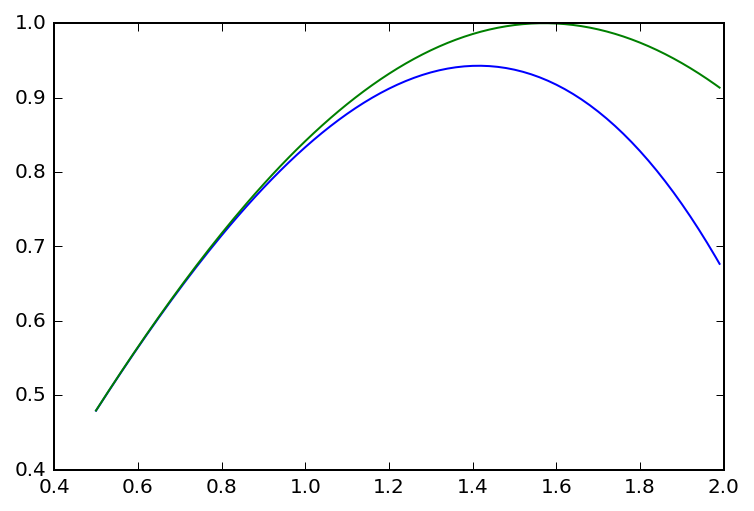

Sub-question 2 :
The given equation is equivalent to the ratio between the forward error and the backward error.
A quick comparison shows that the input the least affected is x = -1

Sub-Question 3 :
1: When computing the power serie with great x (let's say close to infinity), then the true value (sin) should
stay between -1 and 1, when the power serie will go to infinity. Whatever number of terms we use,it can't be periodic as sinus
2:The floating point precision will become very unprecise (say 0.5e-10 evaluated to x^5000,it will loose almost all precision). This is caused by the huge power and floating point limitations
3:To represent the last terms, we will have to compute let's say 5000!, which is not possible to represent precisely with 64 bits. This is caused by the factorial part

Sub-question 4 :
As we can see in the graph, as X gets greater, the two functions separate. This indicates that a
small change in the mantissa will induce a great change in the result if we consider gr

In [6]:
#part 1 

def sinus(x):
    return x - (x**3)/(6)

def absolute_error(f_approx, f_true, x):
    return f_approx(x)-f_true(x)

def relative_error(f_approx, f_true, x):
    return absolute_error(f_approx, f_true, x)/f_true(x)

for i in [-1, 0, 1]:
    x = 2**i   
    print("for x=%s (2^x = %s) :\n" %(i, x))
    forward_relative = relative_error(sinus, np.sin, x)
    print("relative forward error : %s" %(forward_relative))
    backward_absolute = x - np.arcsin(sinus(x))
    backward_relative = backward_absolute/x
    print("relative backward error : %s\n" %(backward_relative))
    
print("We observe that the greater the x, the greater the errors. This is confirmed by the below graph")
    

rangeX = np.arange(0.5, 2, 0.01) ##between 2^(-1) and 2^1
y_sinus = sinus(rangeX)
plt.plot(rangeX, y_sinus)
y_npSin = np.sin(rangeX)
plt.plot(rangeX, y_npSin)
plt.show()


#Part 2
print("Sub-question 2 :\nThe given equation is equivalent to the ratio between the forward error and the backward error.\n"
    + "A quick comparison shows that the input the least affected is x = -1\n")


#Part 3
print("Sub-Question 3 :\n1: When computing the power serie with great x (let's say close to infinity), then the true value (sin) should\n"
         +"stay between -1 and 1, when the power serie will go to infinity. Whatever number of terms we use,"
         +"it can't be periodic as sinus\n"
     +"2:The floating point precision will become very unprecise (say 0.5e-10 evaluated to x^5000," 
         +"it will loose almost all precision). This is caused by the huge power and floating point limitations\n"
     +"3:To represent the last terms, we will have to compute let's say 5000!, which is not possible to "
         +"represent precisely with 64 bits. This is caused by the factorial part\n")

#Part 4
print("Sub-question 4 :\nAs we can see in the graph, as X gets greater, the two functions separate. This indicates that a\n"
     +"small change in the mantissa will induce a great change in the result if we consider great X\n"
     +"This is due to the sine and the power serie starting to heavily diverge from a certain point (around 1.0 considering the graph)")

## Problem 3: Solving quadratic Equations (10+10 points)

Certain types of numerical errors can manifest in sudden and unexpected ways (i.e. significant errors can appear even in short-running computations). Consider the classical formula for computing solutions of the quadratic equation

$$
ax^2 + bx +c = 0 \quad \Leftrightarrow\quad x_{1,2} = \frac{-b \pm \sqrt{b^2-4ac}}{2a}.
$$

Use this expression to compute the two roots corresponding to the following set of coefficients (using 16, 32, and 64 bit floating point formats):

$$
A = 1, B = -54.32, C = 0.1
$$

1. What do you observe? Why is this happening?<br><br>

2. The following mathematically equivalent definition is sometimes used:
$$x_1=\frac{q}{A}, \quad x_2 = \frac{C}{q}$$
  where
$$
\DeclareMathOperator{\sign}{sign}
q = -\frac{1}{2} \left(B + \sign({B}) \sqrt{B^2-4AC}\right).
$$
  Repeat the computation and discuss which of the two formulations is superior.

## Solution 3

In [7]:
#Declarations
A =  1.0
B = -54.32
C =  0.1

#Part 1
for f in [f16, f32, f64]:
    discrimin = f(np.sqrt(f(B**2) - f(4)*f(A)*f(C)))
    x_1 = (-f(B) + discrimin)/(f(2)*f(A))
    x_2 = (-f(B) - discrimin)/(f(2)*f(A))
    print("Precision %s" % (f))
    print("B is %s and discriminant is %s" %(-f(B), discrimin))
    print("Roots are %s and %s\n" % (x_1, x_2))


print("We can observe that the second root with precision 16 is 0. This is due\n"
    + "to the floating point notation : 54.32, with precision 16, is approximated to 54.312,\n"
    + "")
print()

##Part 2
print("Sub-question 2 :")
for f in [f16, f32, f64]:
    q = f(-0.5)*(f(B)+f(np.sign(B))*np.sqrt(f(B)**2 - f(4.0)*f(A)*f(C)))
    x_1 = f(q/f(A))
    x_2 = f(f(C)/q)
    print("Roots are %s and %s with precision %s" % (x_1, x_2, f))

print("As we can see, the second root has 5 correct digit and does not yield a negative answer, even with f16 precision. We can then "
     +"believe that the second method is better.")


Precision <class 'numpy.float16'>
B is 54.312 and discriminant is 54.312
Roots are 54.312 and 0.0

Precision <class 'numpy.float32'>
B is 54.32 and discriminant is 54.3163
Roots are 54.3182 and 0.00184059

Precision <class 'numpy.float64'>
B is 54.32 and discriminant is 54.3163179901
Roots are 54.318158995 and 0.00184100495764

We can observe that the second root with precision 16 is 0. This is due
to the floating point notation : 54.32, with precision 16, is approximated to 54.312,


Sub-question 2 :
Roots are 54.312 and 0.0018406 with precision <class 'numpy.float16'>
Roots are 54.3182 and 0.001841 with precision <class 'numpy.float32'>
Roots are 54.318158995 and 0.00184100495764 with precision <class 'numpy.float64'>
As we can see, the second root has 5 correct digit and does not yield a negative answer, even with f16 precision. We can then believe that the second method is better.


## Problem 4: Vectorization (10+10+10 points)

-- --

Generate a random vector (``np.random.random``) with $10^7$ entries and store it in a global variable. Next, create two functions: the first should compute the sum of the first $N$ entries using a Python ``for`` loop. The second should do the same via ``np.sum()`` and array slicing notation.

Measure the time that is required to run each of these functions for 30 logarithmically spaced values of $N$ ranging from $10^1$ to $10^7$ (hint:  ``np.logspace`` may be useful. The function ``time.time()`` provides a time value in fractional seconds).

Finally, visualize both timing curves in a joint plot with logarithmically spaced horizontal and vertical axes (``plt.loglog()``).

1. The two curves should look very different. What is happening here?<br><br>

2. Focus on the curve corresponding to the ``np.sum()`` implementation. There should be  two clearly different trends for small and large $N$. Where do these come from?<br><br>

3. Divide the ``np.sum()`` measurements by the number of elements corresponding to each call, giving the time spent per entry. Generate another log-log plot of only this curve and justify the trend you observe.

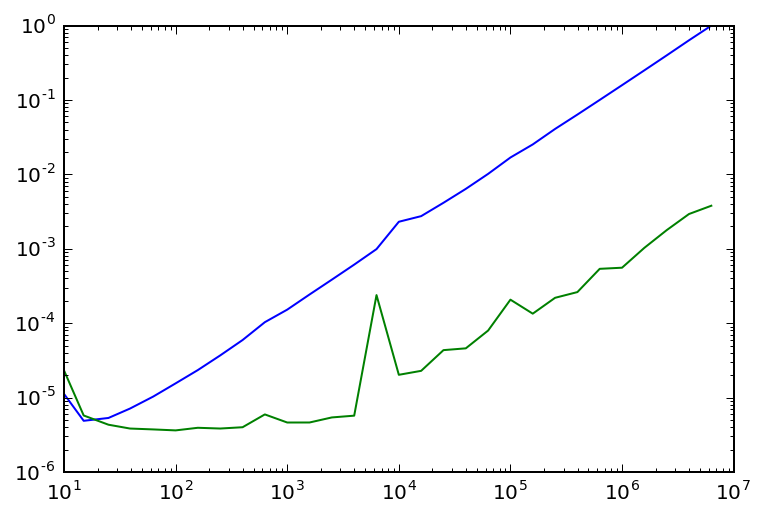

Sub-question 1 :
We see that quickly, the smart sum (using np.sum) is faster than the naive one.
This is due to the internal implementation of both methods, using, among others, parallelism

Sub-question 2 :
Small data are computed in what a short (constant) time, 
when greater values take a lot more time to compute (no more constant). This is due to parallelism,
as for the first values Python will parallelize the computation. From a certain point, the parallelism is
not enough to treat all the remaining values at the same time, and are then computed sequentially (on each thread)


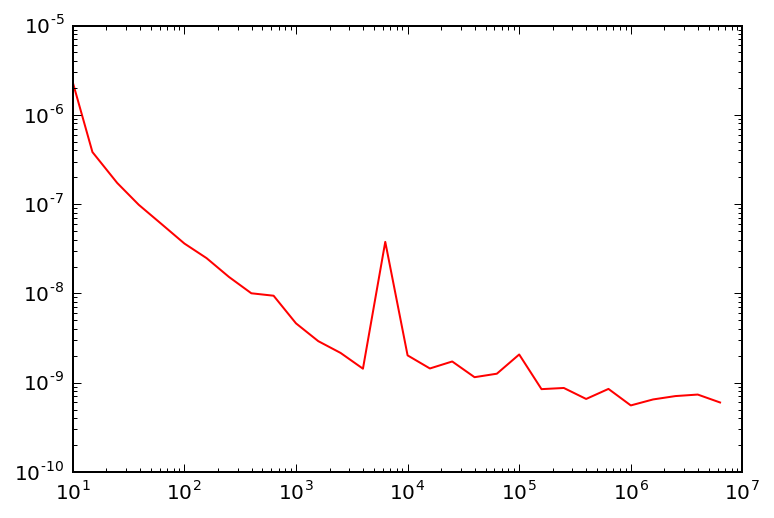

Sub-question 3 :
The time for an addition is approximately constant. As the number of additions grow,
the parallelism becomes more efficient. But as the threads become "saturated", we hit an upper efificency limit (by element)
This explains the "1/x" look of the graph.


In [8]:
size = 10**7
vec = np.random.random(size)

def stupidSum(vector, N):
    sumVec = 0;
    for i in range(N):
        sumVec += vector[i]
    return sumVec

def smartSum(vector, N):
        small = vector[:N]
        return np.sum(small)

log_sample = np.logspace(1, 7, num=30, base=10.0, endpoint=False, dtype=int) ##crée 30 valeurs entières entre 10 et 10^7

computeTimeDumb = np.array([])
computeTimeSmart = np.array([])
dullSum = 0
smart = 0
for i in log_sample:
    before = time.perf_counter() #first timestamp
    dull = stupidSum(vec, i)
    mid = time.perf_counter() #second timestamp
    smart = smartSum(vec, i)
    after = time.perf_counter() #third timestamp
    computeTimeDumb = np.append(computeTimeDumb, np.array([mid-before])) #creating arrays with required times
    computeTimeSmart = np.append(computeTimeSmart, np.array([(after-mid)]))

computeRelativeSmart = computeTimeSmart / log_sample

plt.loglog(log_sample, computeTimeDumb, color="blue") ##blue
plt.loglog(log_sample, computeTimeSmart, color="green") ##green
plt.show()

## Solution 1
print("Sub-question 1 :\nWe see that quickly, the smart sum (using np.sum) is faster than the naive one.\n"
    +"This is due to the internal implementation of both methods, using, among others, parallelism\n")

## Solution 2
print("Sub-question 2 :\nSmall data are computed in what a short (constant) time, \n"
     +"when greater values take a lot more time to compute (no more constant). This is due to parallelism,\n"
     +"as for the first values Python will parallelize the computation. From a certain point, the parallelism is\n"
     +"not enough to treat all the remaining values at the same time, and are then computed sequentially (on each thread)")

##Solution 3
plt.loglog(log_sample, computeRelativeSmart, color="red")
plt.show()

print("Sub-question 3 :\nThe time for an addition is approximately constant. As the number of additions grow,\n"
     +"the parallelism becomes more efficient. But as the threads become \"saturated\", we hit an upper efificency limit (by element)\n"
     +"This explains the \"1/x\" look of the graph.")

## Hacker points (15 points)
-- --

Exercises designated as *hacker points* are undervalued problems that are completely optional (i.e. there is no need to do them to get full grades in this course). However, they will complement your experience and can be useful to offset points lost in other exercises. Partial answers don't count—hacker points are either awarded in full or not at all.

### Interval arithmetic

1. Use ``f2i`` and ``i2f`` to define a new function ``flt_next(value, dir)`` which takes a floating point value ``value`` and a direction ``dir`` (either ``-1`` or ``+1``) to move to the next smaller or larger floating point value, respectively. It should work for positive and negative normalized inputs, though it is fine to ignore special cases such as overflow to infinity, underflow to zero, etc.

  (For future reference: NumPy provides the function ``np.nextafter`` which does exactly this while accounting for all special cases, but here we'll use our own implementation for educational reasons.)<br><br>
  
2. Read up on the rules of interval arithmetic and extend the interval class template below with the methods ``__add__``, ``__sub__``, ``__neg__`` (unary negation), ``__mul__``, ``__truediv__`` (division with fractional result), and ``sqrt``. Since we unfortunately can't adjust the processor's rounding mode in Python, use the following workaround: after every arithmetic operation, use ``flt_next`` to conservatively move the lower and upper interval endpoints down and up by 1 ULP, respectively.<br><br>

3. Use the the finished interval arithmetic class to solve the previous quadratic equation using the "bad" algorithm from Problem 3 (in 16 bit arithmetic). Do the computed intervals bound the roots? How large are they?<br><br>

4. Suppose we aren't confident in the value of coefficient ``A``—however, we can with certainty say that $A\in[0.9, 1.1]$. Use interval arithmetic to determine how this uncertainty propagates to the computed solutions, and which of the two roots is more ambiguous (in absolute terms).

In [9]:
def flt_next(value, dir):
        return i2f(f2i(value) + 1*np.sign(dir))
print(flt_next(4.0, 1))
print(4.32)
print(np.nextafter(4.32, -1))

class Interval:
    """ This class represents a real-valued interval [a, b]. It implements
        various elementary arithmetic operations, which produce intervals
        that bound the set of results which could be obtained by performing
        the same arithmetic operations with interval elements """
    
    def __init__(self, value, extra = None):
        """ Initialize the instance with the specified interval or constant """
        if type(value) is Interval:
            # Initialize with an interval instance
            self.x0, self.x1 = value.x0, value.x1
        else:
            # Initialize with a constant or an interval specified as 2 numbers
            self.x0 = np.array(value)
            self.x1 = np.array(value if extra is None else extra)
        self.dtype = self.x0.dtype
        
    def __repr__(self):
        """ Return a string representation of the interval """
        return "Interval[%f, %f]" % (self.x0, self.x1)
        
    def __add__(self, other):
        """ Add two intervals """
        # Ensure that the other argument is an Interval
        # (to permit addition of a constant to an interval)
        if type(other) is not Interval:
            other = Interval(other)
            
        # Hmm, this is probably not right
        return Interval(0, 1) 

AttributeError: 'float' object has no attribute 'view'